Our first step is to load in the extra packages that we'll be using during our analysis.

In [191]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from library.sb_utils import save_file

In [192]:
tornado_data = pd.read_csv('N://Springboard/Second_Capstone/raw_data/1950-2019_all_tornadoes.csv')
tornado_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66388 entries, 0 to 66387
Data columns (total 29 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   om      66388 non-null  int64  
 1   yr      66388 non-null  int64  
 2   mo      66388 non-null  int64  
 3   dy      66388 non-null  int64  
 4   date    66388 non-null  object 
 5   time    66388 non-null  object 
 6   tz      66388 non-null  int64  
 7   st      66388 non-null  object 
 8   stf     66388 non-null  int64  
 9   stn     66388 non-null  int64  
 10  mag     66388 non-null  int64  
 11  inj     66388 non-null  int64  
 12  fat     66388 non-null  int64  
 13  loss    66388 non-null  float64
 14  closs   66388 non-null  float64
 15  slat    66388 non-null  float64
 16  slon    66388 non-null  float64
 17  elat    66388 non-null  float64
 18  elon    66388 non-null  float64
 19  len     66388 non-null  float64
 20  wid     66388 non-null  int64  
 21  ns      66388 non-null  int64  
 22

Once loaded in, we see that the tornado dataset has 29 different variables, with types that are a mix of int, float, and object, as well as 66388 rows.

In [193]:
tornado_data.head(10)

,om,yr,mo,dy,date,time,tz,st,stf,stn,...,len,wid,ns,sn,sg,f1,f2,f3,f4,fc
0,1,1950,1,3,1/3/1950,11:00:00,3,MO,29,1,...,9.5,150,2,0,1,0,0,0,0,0
1,1,1950,1,3,1/3/1950,11:00:00,3,MO,29,1,...,6.2,150,2,1,2,189,0,0,0,0
2,1,1950,1,3,1/3/1950,11:10:00,3,IL,17,1,...,3.3,100,2,1,2,119,0,0,0,0
3,1,1951,1,6,1/6/1951,17:30:00,3,LA,22,1,...,16.8,317,1,1,1,79,43,0,0,0
4,1,1952,1,17,1/17/1952,19:34:00,3,PA,42,1,...,0.5,400,1,1,1,39,0,0,0,0
5,1,1953,1,7,1/7/1953,20:15:00,3,AR,5,1,...,4.5,100,1,1,1,25,0,0,0,0
6,1,1954,1,20,1/20/1954,5:30:00,3,MS,28,1,...,17.3,27,1,1,1,105,87,0,0,0
7,1,1955,1,5,1/5/1955,5:00:00,3,OK,40,1,...,0.1,10,1,1,1,51,0,0,0,0
8,1,1956,1,28,1/28/1956,21:30:00,3,AR,5,1,...,23.0,150,1,1,1,45,145,0,0,0
9,1,1957,1,21,1/21/1957,13:20:00,3,HI,15,1,...,2.5,10,1,1,1,3,0,0,0,1


Inspecting the first ten rows of the dataset shows us a few different things. First we notice the om column, which is a tornado identifier item. We don't see it here, but we know from reading the documentation that there is not a 1:1 relationship between unique om numbers and rows. om numbers reset each year, and further, if a tornado passes through more than 4 counties, the 5th/9th/etc. counties create a new row with the same om value. Similarly, if a tornado crosses into any additional states, each state will have its own row. 

We then see that the next 4 columns are all date related, representing year, month, day, and aggregated date. 

 This is followed by: <br /> 
 - Time data (time and time zone) <br />
 - Geographic data (state id, state number) <br />
 - The number of that tornado in that state for that year <br />
 - The magnitude of the tornado (on the F or EF-scale depending on year) <br />
 - Human toll (fatalities, injuries) <br />
 - Economic damage (property damage, crop damage) <br />
 - Geographic track (starting latitude and longitude, ending latitude and longitude, and length of the track in miles) <br />
 - Width of the tornado in yards <br />


The last 7 columns all relate to the geographies (counties, states) impacted by the tornado's track, and are not easy to parse without taking a hard look at the documentation.

ns, sn, and sg create a coded set of three numbers that tells us the following: <br />
   - ns = number of states affected by the tornado <br />
   - sn = the state number for the specific row. Can be 1 or 0. <br />
   - sg = the segment track number for the specific row. Can be 1, 0, or -9. <br />

As mentioned above, there are 3 different scenarios that would produce multiple rows with the same om identifier: <br />
   - A tornado moves through more than 4 counties. For this, the first row would be (1,1,1) meaning one state, first state, and 
        first row. The second (and any subsequent) row would be coded (1,0,-9) <br />
   - A tornado moves through 2 or more states, but never through more than 4 counties in any state. For this, the first row
        would be (2,0,1) or (3,0,1), since none of the tornadoes in the dataset passed through more than 3 states. 2 or 3 is 
        the number of states impacted, 0 signifies that the row does not contain the full track information for the tornado, 
        and 1 shows that this is the first segment. Subsequent rows would either be (2,1,2) or (3,1,2),(3,1,2). <br />
   - A tornado moves through 2 or more states, also moving through more than 4 counties in one or more of the states. This 
        scenario mirrors the one above, but with the addition of (2,0,-9)/(3,0,-9), which signifies the continuing county 
        codes for a (2,1,2)/(3,1,2) state entry. <br />
        
Tied to these codes are the 4 county FIPS code slots: f1, f2, f3, and f4. If there are only 2 counties impacted, f3 and f4 will be zero. If 3 counties, f4 will be zero. If the row you're examining is a (#,0,-9) code, then f1 actually represents the 5th, 9th, etc. county.

This is the web we need to untangle through our data cleaning. Since we're going to be using county-level population, area, and home-age data, we want each row to represent a single tornado with a unique identifier, with the number of county columns expanded to account for the maximum number of impacted counties. In order to maintain state-level information, we'll also create 3 state columns to mirror the county columns as well.

First, we'll make things easier to read by giving some of the columns more descriptive labels.

In [194]:
tornado_data.rename(columns={'stf':'state_fips', 'stn':'state_num', 'closs':'crop_loss', 'slat':'start_lat', "slon":"start_lon", 'elat':'end_lat', 'elon':'end_lon', 'ns':'num_of_states', 'sn':'tr_state_num', 'sg':'seg_num', 'f1':'county_1', 'f2':'county_2', 'f3':'county_3', 'f4':'county_4'}, inplace=True)
tornado_data.head()

,om,yr,mo,dy,date,time,tz,st,state_fips,state_num,...,len,wid,num_of_states,tr_state_num,seg_num,county_1,county_2,county_3,county_4,fc
0,1,1950,1,3,1/3/1950,11:00:00,3,MO,29,1,...,9.5,150,2,0,1,0,0,0,0,0
1,1,1950,1,3,1/3/1950,11:00:00,3,MO,29,1,...,6.2,150,2,1,2,189,0,0,0,0
2,1,1950,1,3,1/3/1950,11:10:00,3,IL,17,1,...,3.3,100,2,1,2,119,0,0,0,0
3,1,1951,1,6,1/6/1951,17:30:00,3,LA,22,1,...,16.8,317,1,1,1,79,43,0,0,0
4,1,1952,1,17,1/17/1952,19:34:00,3,PA,42,1,...,0.5,400,1,1,1,39,0,0,0,0


Next, we'll use the om number (which identifies each tornado by number, but repeats each year) combined with the year column to create a unique identifier for each tornado. We'll put this id into a new column called "temp_id". Note that while this is a unique **tornado** identifier, it is not yet a unique **row** identifier. 

In [195]:
tornado_data['temp_id'] = tornado_data.apply(lambda x:'%s_%s' % (x['yr'],x['om']),axis=1)
temp_id = tornado_data['temp_id']
tornado_data.drop(labels=['temp_id'], axis=1,inplace = True)
tornado_data.insert(1, 'temp_id', temp_id)
tornado_data

dup_id = tornado_data[temp_id.isin(temp_id[temp_id.duplicated()])].sort_values("temp_id")
dup_id

,om,temp_id,yr,mo,dy,date,time,tz,st,state_fips,...,len,wid,num_of_states,tr_state_num,seg_num,county_1,county_2,county_3,county_4,fc
0,1,1950_1,1950,1,3,1/3/1950,11:00:00,3,MO,29,...,9.50,150,2,0,1,0,0,0,0,0
1,1,1950_1,1950,1,3,1/3/1950,11:00:00,3,MO,29,...,6.20,150,2,1,2,189,0,0,0,0
2,1,1950_1,1950,1,3,1/3/1950,11:10:00,3,IL,17,...,3.30,100,2,1,2,119,0,0,0,0
1307,22,1950_22,1950,2,12,2/12/1950,14:20:00,3,LA,22,...,0.00,0,1,0,-9,27,0,0,0,0
1306,22,1950_22,1950,2,12,2/12/1950,14:00:00,3,LA,22,...,74.50,100,1,1,1,85,69,81,13,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66333,618491,2019_618491,2019,12,16,12/16/2019,11:08:00,3,LA,22,...,11.70,600,2,0,1,0,0,0,0,0
66335,618491,2019_618491,2019,12,16,12/16/2019,11:09:00,3,MS,28,...,11.18,600,2,1,2,21,149,0,0,0
66363,618518,2019_618518,2019,12,16,12/16/2019,17:59:00,3,MS,28,...,51.28,350,2,1,2,67,153,23,0,0
66362,618518,2019_618518,2019,12,16,12/16/2019,17:59:00,3,MS,28,...,61.19,350,2,0,1,0,153,23,0,0


Running .duplicated shows us that the multi-row-per-tornado issue affects nearly 1900 rows.

In [196]:
# For ease of linking additional county-level datasets, we want all county and state ids to be formatted in the same manner (3 and 2-digits respectively, with or without leading zeroes).

for column in tornado_data[['county_1', 'county_2', 'county_3', 'county_4']]:
    tornado_data[column] = tornado_data[column].map("{:003}".format)
tornado_data[['county_1', 'county_2', 'county_3', 'county_4']]

tornado_data['state_fips'] = tornado_data['state_fips'].map("{:02}".format)
tornado_data['state_fips']

0        29
1        29
2        17
3        22
4        42
         ..
66383    28
66384    28
66385    28
66386    28
66387    01
Name: state_fips, Length: 66388, dtype: object

In [197]:
# In order to more easily concatenate state+county ids, we convert these columns to strings instead of ints.

convert_dict = {'state_fips': str,
                'county_1': str,
                'county_2': str,
                'county_3': str,
                'county_4': str,
               }
  
tornado_data = tornado_data.astype(convert_dict)
print(tornado_data.dtypes)

om                 int64
temp_id           object
yr                 int64
mo                 int64
dy                 int64
date              object
time              object
tz                 int64
st                object
state_fips        object
state_num          int64
mag                int64
inj                int64
fat                int64
loss             float64
crop_loss        float64
start_lat        float64
start_lon        float64
end_lat          float64
end_lon          float64
len              float64
wid                int64
num_of_states      int64
tr_state_num       int64
seg_num            int64
county_1          object
county_2          object
county_3          object
county_4          object
fc                 int64
dtype: object


In [198]:
for column in tornado_data[['county_1', 'county_2', 'county_3', 'county_4']]:
    tornado_data.loc[tornado_data[column] == '000', column] = '000'
    tornado_data.loc[tornado_data[column] != '000', column] = tornado_data['state_fips'].str.cat(tornado_data[column].copy(), sep="", na_rep="")

print(tornado_data[['county_1', 'county_2', 'county_3', 'county_4']])



      county_1 county_2 county_3 county_4
0          000      000      000      000
1        29189      000      000      000
2        17119      000      000      000
3        22079    22043      000      000
4        42039      000      000      000
...        ...      ...      ...      ...
66383    28007      000      000      000
66384    28019      000      000      000
66385    28105      000      000      000
66386    28101      000      000      000
66387    01083      000      000      000

[66388 rows x 4 columns]


Now that we have the county and state identifiers combined into a single id for each entry, we next need to combine all of the ids in each tornado track into a list for easier manipulation.

In [199]:
counties_df = tornado_data[['temp_id', 'county_1', 'county_2', 'county_3', 'county_4']].copy()
cols = ['county_1','county_2','county_3', 'county_4']
counties_df['counties_list'] = counties_df[cols].values.tolist()
counties_df2 = counties_df.groupby('temp_id').agg(lambda x: x.to_list())
counties_df2['counties_list'] = counties_df2['counties_list'].apply(np.ravel)
print(counties_df2['counties_list'])


temp_id
1950_1         [000, 000, 000, 000, 29189, 000, 000, 000, 171...
1950_10                                   [48423, 000, 000, 000]
1950_100                                  [22009, 000, 000, 000]
1950_101                                  [48157, 000, 000, 000]
1950_102                                  [37123, 000, 000, 000]
                                     ...                        
2019_618537                               [28007, 000, 000, 000]
2019_618538                               [28019, 000, 000, 000]
2019_618539                               [28105, 000, 000, 000]
2019_618540                               [28101, 000, 000, 000]
2019_618541                               [01083, 000, 000, 000]
Name: counties_list, Length: 65160, dtype: object


In [200]:
# Removing empty entries by filtering out '000' strings.

counties_df2['counties_list'] = counties_df2['counties_list'].apply(lambda x: [i for i in x if str(i) != "000"])
print(counties_df2['counties_list'])
   

temp_id
1950_1         [29189, 17119]
1950_10               [48423]
1950_100              [22009]
1950_101              [48157]
1950_102              [37123]
                    ...      
2019_618537           [28007]
2019_618538           [28019]
2019_618539           [28105]
2019_618540           [28101]
2019_618541           [01083]
Name: counties_list, Length: 65160, dtype: object


In [201]:
print(max(counties_df2['counties_list'], key=len))

['01107', '01125', '01057', '01125', '01057', '01127', '01043', '01009', '01043', '01009', '01043', '01009', '01043', '01009', '01095']


From this, we see that the longest list of counties is 15 counties long. But there's something else we notice: There are several counties that appear in the list mulitple times. This means that the tornado likely followed the county line, meandering back and forth across it and generating a new entry every time it did so.

This is interesting information, but will unnecessarily complicate matters when we start attempting to link county-specific data to this dataset. As such, we want to modify these lists in such a way that we only keep the first instance of a county id within a list.

In [202]:
# Using the set function removes duplicate values.

counties_df2['counties_list'] = counties_df2['counties_list'].apply(set)
print(max(counties_df2['counties_list'], key=len))

{'13005', '13087', '13179', '13183', '13305', '13069', '13253', '13075', '13131', '13205', '13071'}


Now the longest county list is 11 counties long, but has no id duplicates. Thus we need 11 county columns in our primary dataset in order to hold all records in a single row. We proceed by creating 11 county columns and distributing the ids across them.

In [203]:
counties_df2['counties_list'] = counties_df2['counties_list'].apply(list)
counties_df2[['county_1','county_2', 'county_3', 'county_4', 'county_5', 'county_6', 'county_7', 'county_8', 'county_9', 'county_10', 'county_11' ]] = pd.DataFrame(counties_df2.counties_list.tolist(), index= counties_df2.index)
counties_df2.drop(['counties_list'], axis = 1, inplace=True)
counties_df2

,county_1,county_2,county_3,county_4,county_5,county_6,county_7,county_8,county_9,county_10,county_11
temp_id,,,,,,,,,,,
1950_1,17119,29189,None,None,None,None,None,None,None,None,None
1950_10,48423,None,None,None,None,None,None,None,None,None,None
1950_100,22009,None,None,None,None,None,None,None,None,None,None
1950_101,48157,None,None,None,None,None,None,None,None,None,None
1950_102,37123,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...
2019_618537,28007,None,None,None,None,None,None,None,None,None,None
2019_618538,28019,None,None,None,None,None,None,None,None,None,None
2019_618539,28105,None,None,None,None,None,None,None,None,None,None


In [204]:
counties_df2.to_csv('C:/Users/Mavis/Desktop/county_onerow.csv')

The next step is to do the same for state codes that we did for counties. No tornado impacted more than 3 states, so we need only 3 new state columns. We use string slicing to remove the first 2 characters (the state code) from each county ID, remove duplicates, and distribute them across the new state columns.

We then drop the temporary columns we used to perform the transformation.

In [205]:
counties_df2['sl1'] = counties_df2['county_1'].str.slice(0,2)
counties_df2['sl2'] = counties_df2['county_2'].str.slice(0,2)
counties_df2['sl3'] = counties_df2['county_3'].str.slice(0,2)
counties_df2['sl4'] = counties_df2['county_4'].str.slice(0,2)
counties_df2['sl5'] = counties_df2['county_5'].str.slice(0,2)
counties_df2['sl6'] = counties_df2['county_6'].str.slice(0,2)
counties_df2['sl7'] = counties_df2['county_7'].str.slice(0,2)
counties_df2['sl8'] = counties_df2['county_8'].str.slice(0,2)
counties_df2['sl9'] = counties_df2['county_9'].str.slice(0,2)
counties_df2['sl10'] = counties_df2['county_10'].str.slice(0,2)
counties_df2['sl11'] = counties_df2['county_11'].str.slice(0,2)

st_cols = ['sl1', 'sl2', 'sl3', 'sl4', 'sl5', 'sl6', 'sl7', 'sl8', 'sl9', 'sl10', 'sl11']
counties_df2['states_list'] = counties_df2[st_cols].values.tolist()
counties_df2['states_list'] = counties_df2['states_list'].apply(lambda x: [i for i in x if str(i) != "None"])
counties_df2['states_list'] = counties_df2['states_list'].apply(set)
counties_df2[['state_1', 'state_2', 'state_3']] = pd.DataFrame(counties_df2.states_list.tolist(), index= counties_df2.index)

counties_df2.drop(['states_list'], axis = 1, inplace=True)
counties_df2.drop(['sl1', 'sl2', 'sl3', 'sl4', 'sl5', 'sl6', 'sl7', 'sl8', 'sl9', 'sl10', 'sl11'], axis = 1, inplace=True)
counties_df2



,county_1,county_2,county_3,county_4,county_5,county_6,county_7,county_8,county_9,county_10,county_11,state_1,state_2,state_3
temp_id,,,,,,,,,,,,,,
1950_1,17119,29189,None,None,None,None,None,None,None,None,None,17,29,None
1950_10,48423,None,None,None,None,None,None,None,None,None,None,48,None,None
1950_100,22009,None,None,None,None,None,None,None,None,None,None,22,None,None
1950_101,48157,None,None,None,None,None,None,None,None,None,None,48,None,None
1950_102,37123,None,None,None,None,None,None,None,None,None,None,37,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019_618537,28007,None,None,None,None,None,None,None,None,None,None,28,None,None
2019_618538,28019,None,None,None,None,None,None,None,None,None,None,28,None,None
2019_618539,28105,None,None,None,None,None,None,None,None,None,None,28,None,None


With a single row for each tornado, and a column for each county and state in its track, this data is now ready to be rejoined to the main dataset.

But first, we must consolidate the information for each tornado in the main dataset down to a single row. Luckily, all of the relevant information is contained as a 'parent' row, which is either a summation of the individual state rows for multi-state tornadoes, or the full track data for single-state tornadoes impacting more than 4 counties. 

As learned in the documentation, multi-row tornadoes are classified by their 3-digit code found in the ns/sn/sg columns, and the parent rows belong to one of three different codes: 1,1,1, 2,0,1, and 3,0,1. In order to make code-matching easier, we'll first concatenate the three columns into 1 with a comma separator, and drop the original columns.

In [206]:
code_cols = ['num_of_states', 'tr_state_num', 'seg_num']
tornado_data['concat_code'] = tornado_data[code_cols].apply(lambda row: ','.join(row.values.astype(str)), axis=1)
tornado_data.drop(['num_of_states', 'tr_state_num', 'seg_num'], axis = 1, inplace=True)
tornado_data.head(10)


,om,temp_id,yr,mo,dy,date,time,tz,st,state_fips,...,end_lat,end_lon,len,wid,county_1,county_2,county_3,county_4,fc,concat_code
0,1,1950_1,1950,1,3,1/3/1950,11:00:00,3,MO,29,...,38.83,-90.03,9.5,150,000,000,000,000,0,"2,0,1"
1,1,1950_1,1950,1,3,1/3/1950,11:00:00,3,MO,29,...,38.82,-90.12,6.2,150,29189,000,000,000,0,"2,1,2"
2,1,1950_1,1950,1,3,1/3/1950,11:10:00,3,IL,17,...,38.83,-90.03,3.3,100,17119,000,000,000,0,"2,1,2"
3,1,1951_1,1951,1,6,1/6/1951,17:30:00,3,LA,22,...,31.53,-92.40,16.8,317,22079,22043,000,000,0,"1,1,1"
4,1,1952_1,1952,1,17,1/17/1952,19:34:00,3,PA,42,...,0.00,0.00,0.5,400,42039,000,000,000,0,"1,1,1"
5,1,1953_1,1953,1,7,1/7/1953,20:15:00,3,AR,05,...,33.87,-92.10,4.5,100,05025,000,000,000,0,"1,1,1"
6,1,1954_1,1954,1,20,1/20/1954,5:30:00,3,MS,28,...,33.47,-88.62,17.3,27,28105,28087,000,000,0,"1,1,1"
7,1,1955_1,1955,1,5,1/5/1955,5:00:00,3,OK,40,...,0.00,0.00,0.1,10,40051,000,000,000,0,"1,1,1"
8,1,1956_1,1956,1,28,1/28/1956,21:30:00,3,AR,05,...,35.33,-92.08,23.0,150,05045,05145,000,000,0,"1,1,1"
9,1,1957_1,1957,1,21,1/21/1957,13:20:00,3,HI,15,...,21.52,-158.07,2.5,10,15003,000,000,000,1,"1,1,1"


We now need to keep the 'parent' rows that summarize the full track information, and remove the 'child' rows so that each temp_id will be unique. Again, parent rows in concat_code are represented by either 1,1,1, 2,0,1, or 3,0,1, so we create a list with these codes and use it to filter the dataset. 

We'll also take this opportunity to remove columns we won't be using in our analysis, namely those for time zone, om number (replaced by temp_id), crop_loss (only populated after 2007), and f-scale conversion status.

In [207]:
parents = ['1,1,1', '2,0,1', '3,0,1']
tornado_data = tornado_data[tornado_data['concat_code'].isin(parents)]
tornado_data.drop(['tz', 'om', 'fc', 'crop_loss'], inplace=True, axis=1)
tornado_data.drop(['county_1', 'county_2', 'county_3', 'county_4'], inplace=True, axis=1)
tornado_data

,temp_id,yr,mo,dy,date,time,st,state_fips,state_num,mag,inj,fat,loss,start_lat,start_lon,end_lat,end_lon,len,wid,concat_code
0,1950_1,1950,1,3,1/3/1950,11:00:00,MO,29,1,3,3,0,6.0,38.7700,-90.2200,38.8300,-90.0300,9.50,150,"2,0,1"
3,1951_1,1951,1,6,1/6/1951,17:30:00,LA,22,1,3,11,0,5.0,31.3000,-92.4700,31.5300,-92.4000,16.80,317,"1,1,1"
4,1952_1,1952,1,17,1/17/1952,19:34:00,PA,42,1,2,0,0,5.0,41.6000,-80.3000,0.0000,0.0000,0.50,400,"1,1,1"
5,1953_1,1953,1,7,1/7/1953,20:15:00,AR,05,1,2,2,0,3.0,33.8300,-92.1700,33.8700,-92.1000,4.50,100,"1,1,1"
6,1954_1,1954,1,20,1/20/1954,5:30:00,MS,28,1,2,2,0,4.0,33.3000,-88.8300,33.4700,-88.6200,17.30,27,"1,1,1"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66383,2019_618537,2019,12,29,12/29/2019,16:03:00,MS,28,0,1,0,0,75000.0,33.1628,-89.4323,33.2339,-89.3298,7.70,900,"1,1,1"
66384,2019_618538,2019,12,29,12/29/2019,16:13:00,MS,28,0,1,0,0,10000.0,33.2598,-89.2778,33.2879,-89.2208,3.82,200,"1,1,1"
66385,2019_618539,2019,12,29,12/29/2019,16:32:00,MS,28,0,0,0,0,5000.0,33.4720,-89.0315,33.4888,-88.9910,2.61,200,"1,1,1"
66386,2019_618540,2019,12,29,12/29/2019,17:13:00,MS,28,0,1,0,0,150000.0,32.5268,-89.1628,32.5581,-89.1215,3.23,125,"1,1,1"


We're now close to having the dataset in the format we desire. All that remains is to re-populate the county and state track information for the newly-unique rows. This is done with a simple merge on the temp_id field in both dataframes.

In [208]:
df = pd.merge(tornado_data, counties_df2, how='inner', on=['temp_id'])
df.head()
df.to_csv('C:/Users/Mavis/Desktop/fulldata.csv')

Now that we have our base dataset in the format that we like, we'll do some quick analysis to see if any further cleaning is needed. First we'll examine our numerical columns to see if anything looks unusual.

In [209]:
df.describe().apply(lambda s: s.apply('{0:.5f}'.format)).T


,count,mean,std,min,25%,50%,75%,max
yr,65162.00000,1990.26769,18.83772,1950.00000,1975.00000,1993.00000,2006.00000,2019.00000
mo,65162.00000,5.95927,2.41196,1.00000,4.00000,6.00000,7.00000,12.00000
dy,65162.00000,15.93206,8.75989,1.00000,8.00000,16.00000,24.00000,31.00000
state_num,65162.00000,24.42516,32.16989,0.00000,2.00000,13.00000,33.00000,232.00000
mag,65162.00000,0.73808,1.11557,-9.00000,0.00000,1.00000,1.00000,5.00000
inj,65162.00000,1.46602,18.45280,0.00000,0.00000,0.00000,0.00000,1740.00000
fat,65162.00000,0.09103,1.48946,0.00000,0.00000,0.00000,0.00000,158.00000
loss,65162.00000,70394.18074,6815636.09893,0.00000,0.00000,0.10000,4.00000,1550000000.00000
start_lat,65162.00000,37.13896,5.10419,17.72120,33.20537,37.05000,40.93000,61.02000
start_lon,65162.00000,-92.87181,8.69615,-163.53000,-98.52000,-93.75000,-86.82000,-64.71510


We didn't expect anything particularly interesting in the yr/mo/dy or state_num columns, but it's good to see via min and max that there don't appear to be any outliers, which would indicate mis-coded values.

We know that both the F-Scale and EF-Scale for tornadoes runs from 1-5, so the '-9' likely implies missing data. According to the documentation, -9 = 'unknown', so we'll need to decide what to do with these missing values.

Injuries and fatalities both show what looks like a potentially skewed distribution. The 75th-percentile for each is 0, but the maximums are 1740 and 158 respectively. This implies that a significant human toll from tornadoes might actually be a somewhat rare occurrence overall.

The loss column is an immediate concern. A max of 1.55 *Billion* with a 75th-percentile value of 4 implies a significant disconnect. Again, the documentation makes clear the issue:

> Estimated property loss information - Prior to 1996 this is a categorization of tornado damage by dollar amount (0 or blank-unknown; 1=less than \\$50, 2 =\\$50-\\$500, 3 =\\$500-\\$5,000, 4 = \\$5,000-\\$50,000, 5 = \\$50,000-\\$500,000, 6 = \\$500,000-\\$5,000,000, 7 = \\$5,000,000-\\$50,000,000, 8 = \\$50,000,000-\\$500,000,000, 9 = \\$500,000,000-\\$5,000,000,000). From 1996, this is tornado property damage in millions of dollars. Note: this may change to whole dollar amounts in the future. Entry of 0 does not mean \\$0. <br />

We definitely have at least two different formats for this property loss data, but there's also an implied third. A maximum of 1.5B only makes sense if that amount is in whole dollars as opposed to millions of dollars. (For context, Hurricane Katrina "only" caused $161B in damage). We will investigate further to see whether this was a scheduled change sometime after 1996 or if it's simply a mis-coded value before we re-scale the rest of the data.

Our concern with latitude and longitude is simply making sure the values all fall somewhere within the United States and its territories. Consulting latlong.net, the min value of 17.72 deg latitude lines up with the US Virgin Islands, and the max of 61.02 deg latitude crosses Alaska, so these are both reasonable. Similarly the min value of -163 deg longitude passes through western Alaska, an the max value of -64.7 deg longitude crosses the US Virgin Islands. We do see, however, an unexpected null value in the minimum for ending latitude and maximum for ending Longitude. We'll explore this further to see whether there are multiple nulls, and whether these values can be populated or if the records need to be removed.

The maximum values for track length (in miles) and tornado width (in yards) do seem a bit high but not unreasonably so. We can chart these values to see if they're truly outliers. Again we see that there's at least one record showing 0s for both categories, so we'll see how widespread that is and decide what to do with the null values.

First, we'll take a look at the tornadoes with unknown (-9) magnitude. How many are there? Do they contain other data that we need to retain, or can they safely be discarded? Given that the majority of the analysis we'll be performing will center on injuries, fatalities, and property loss, that's what we'll focus on to determine whether these rows contain necessary data.

In [210]:
df_unknown = df.query('mag == -9')
print(df_unknown.mag.count())

print(df_unknown['inj'].sum())
print(df_unknown['fat'].sum())
print(df_unknown['loss'].sum())


298
0
0
0.0


We see that there are 298 tornadoes for which the magnitude is unknown (approximately 0.4% of our dataset), and none of these records contain any data in the 3 impact categories we're primarily concerned with. We will do some grouping of tornadoes by geography, but this is not reason enough to hold on to these records. We will instead remove them.

In [211]:
# Dropping tornado records with unknown magnitude from the dataframe.
df = df[df.mag != -9]

The next thing we'll take a look at is whether the maxima for Injuries, Fatalities, Track Length, and Tornado Width are outliers or relevant data. We'll determine this using histograms for each category.

In [212]:
plt.rcParams["figure.figsize"] = (20,8)

Text(0.5, 1.0, 'Width (yds)')

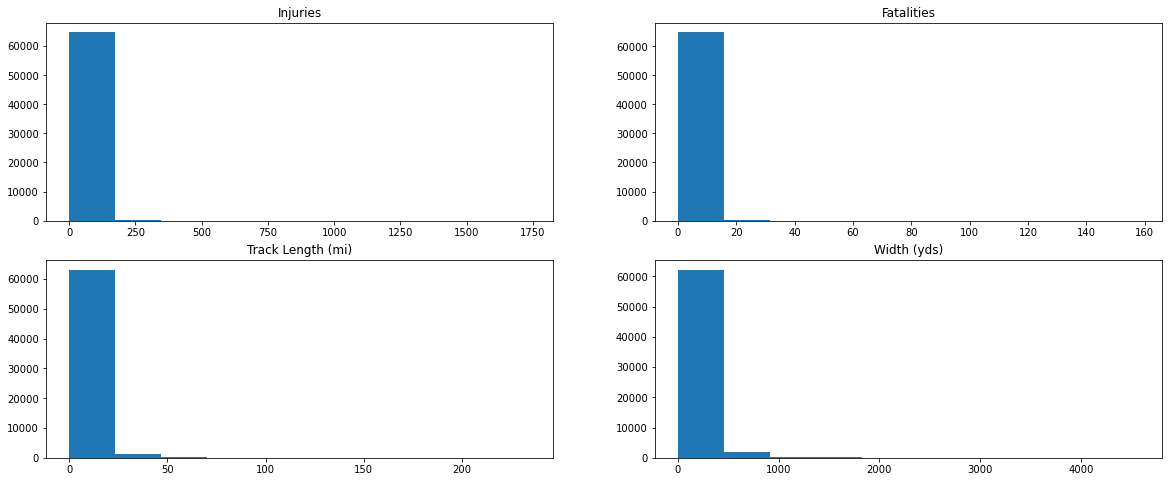

In [213]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

ax1.hist(df['inj'])
ax1.set_title('Injuries')
ax2.hist(df['fat'])
ax2.set_title('Fatalities')
ax3.hist(df['len'])
ax3.set_title('Track Length (mi)')
ax4.hist(df['wid'])
ax4.set_title('Width (yds)')

It's clear that the vast majority of tornadoes are less than 1000 yds wide, on the ground for less than 50 miles, and cause minimal injuries and deaths. But this heavy left-skew makes it difficult to ascertain whether the maximums in these categories are reasonable or outliers. To account for this, we'll filter the histograms to exclude the most common values.

Text(0.5, 1.0, 'Width (yds)')

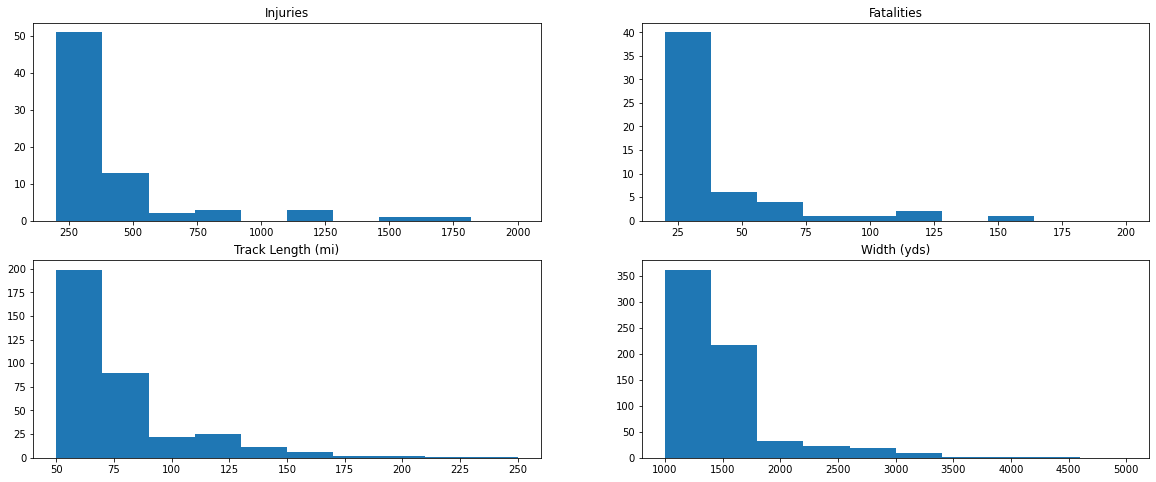

In [214]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

ax1.hist(df['inj'], range=[200,2000])
ax1.set_title('Injuries')
ax2.hist(df['fat'], range=[20,200])
ax2.set_title('Fatalities')
ax3.hist(df['len'], range=[50,250])
ax3.set_title('Track Length (mi)')
ax4.hist(df['wid'], range=[1000,5000])
ax4.set_title('Width (yds)')

Now we see the long sloping tail to the right for each distribution, and none have large gaps prior to their maximum. As such, we can conclude that the maximum values for these 4 categories are indeed relevant data points and not outliers.

The last data fidelity issue we must address is the disconnect in how property loss is handled across years in the dataset. We already know that there is a shift from an integer scale to \\$M in 1996, and we suspect as well that this changed from \\$M to whole dollars at some point prior to 2019.

Given that it would be impossible to determine precise \\$M or \\$ values for pre-1996 tornadoes, we'll instead go the other direction and convert post-1996 tornado damage to the integer scale used previously. First, however, we need to determine if there was a change from \\$M to \\$ that we need to account for.

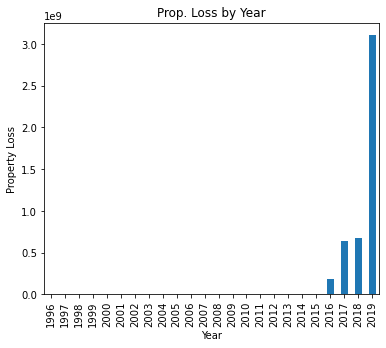

In [215]:
df_recent = df.query('yr >= 1996')
df_recent = df_recent.groupby(['yr'])['loss'].sum()

df_recent.plot(kind='bar', title='Prop. Loss by Year', ylabel='Property Loss',
         xlabel='Year', figsize=(6, 5))
plt.show()

By plotting property loss over time this way, we see two things. The first (and most important) is that it appears the previously mentioned shift to whole dollars instead of $M occurred sometime in 2016.

The second, which we'll set aside but will need to revisit, is how much higher the property loss total is for 2019. We can only compare it to 2016-2018 at the current scale, but the difference is stark. It'll be important to determine whether this is caused by # of tornadoes or a single outlier.

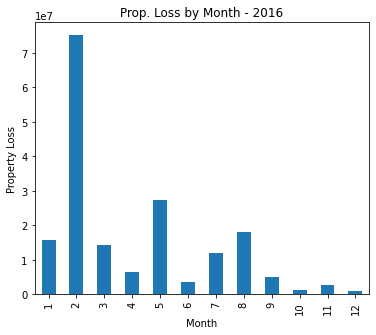

In [216]:
df_2016 = df.query('yr == 2016')
df_2016 = df_2016.groupby(['mo'])['loss'].sum()

df_2016.plot(kind='bar', title='Prop. Loss by Month - 2016', ylabel='Property Loss',
         xlabel='Month', figsize=(6, 5))
plt.show()

Since all months are visible on this scale, it seems clear that the shift to whole dollars occurred right at the start of 2016. This clear demarcation will help to simplify the process of marrying the data from before and after the change.


In [217]:
df.loc[(df.yr >= 2016 ), 'loss' ] /= 1000000


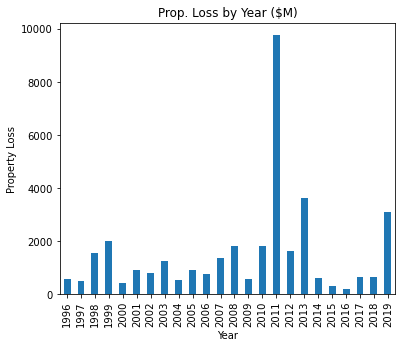

In [218]:
df_recent = df.query('yr >= 1996')
df_recent = df_recent.groupby(['yr'])['loss'].sum()

df_recent.plot(kind='bar', title='Prop. Loss by Year ($M)', ylabel='Property Loss',
         xlabel='Year', figsize=(6, 5))
plt.show()

This chart shows us that dividing 2016-2019 tornado losses by 1M did what we expected and brought them in line with the rest of 1996-2015. We can now move on and convert all >1996 losses to the integer scale used previously.

It also addresses the issue we set to the side earlier: The "high" property loss levels for 2019 were only extreme when compared to the 3 years preceding. On the other hand, we might now need to investigate 2011 instead, as its sum is nearly 2.5x higher than any other single year in the range. 


In [219]:
df.loc[(df.loss > 0) & (df.loss < 0.00005) & (df.yr >= 1996), 'loss'] = 1
df.loc[(df.loss >= 0.00005) & (df.loss < 0.0005) & (df.yr >= 1996), 'loss'] = 2
df.loc[(df.loss >= 0.0005) & (df.loss < 0.005) & (df.yr >= 1996), 'loss'] = 3
df.loc[(df.loss >= 0.005) & (df.loss < 0.05) & (df.yr >= 1996), 'loss'] = 4
df.loc[(df.loss >= 0.05) & (df.loss < 0.5) & (df.yr >= 1996), 'loss'] = 5
df.loc[(df.loss >= 0.5) & (df.loss < 5) & (df.yr >= 1996), 'loss'] = 6
df.loc[(df.loss >= 5) & (df.loss < 50) & (df.yr >= 1996), 'loss'] = 7
df.loc[(df.loss >= 50) & (df.loss < 500) & (df.yr >= 1996), 'loss'] = 8
df.loc[(df.loss >= 500) & (df.loss < 5000) & (df.yr >= 1996), 'loss'] = 9

In [220]:
df.loss.describe()

count    64864.000000
mean         3.103154
std          2.840504
min          0.000000
25%          0.000000
50%          3.000000
75%          6.000000
max          9.000000
Name: loss, dtype: float64

With a min of 0.000 and a max of 9.000, we know that the process to redistribute >1996 property losses into the integer scale was successful.

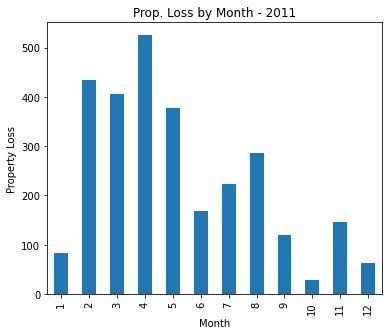

In [221]:
df_2011 = df.query('yr == 2016')
df_2011 = df_2011.groupby(['mo'])['loss'].sum()

df_2011.plot(kind='bar', title='Prop. Loss by Month - 2011', ylabel='Property Loss',
         xlabel='Month', figsize=(6, 5))
plt.show()

Circling back to 2011, we see that the distribution of property loss is not skewed toward any particular month (which could imply a possible outlier). Instead, it seems that 2011 was simply an extremely heavy year for property loss caused by tornadoes. 

The last piece we need to address is the potentially missing data we observed for ending latitude/longitude.

In [222]:
df_null_lon = df.query('end_lon == 0')
print(df_null_lon.end_lon.count())
df_null_lat = df.query('end_lat == 0')
print(df_null_lat.end_lat.count())

26363
26363


It looks like missing end lat/lon data affects ~26k rows, but no rows are missing only one of the two. That's a fairly significant portion of our total dataset, so we would prefer not to have to drop these rows. 

Looking at our analysis holistically, the only thing we plan to use the lat/lon categories for is to see whether the "core" tornado producing area has shifted or expanded over time. And given that we don't have null values for *starting* lat/lon, our missing data will only be truly impactful for tornadoes with very long tracks (since only those records would have a significant difference between starting and ending lat/lon). Thus we would like to know two things: 1) Is length data available for these 26k rows? and 2) What proportion of those 26k rows represent a track length of <5.5 miles? (5.5 miles being the approximate distance equivalent of a 0.1 degree change in longitude).

In [223]:
df.loc[(df['end_lon'] == 0) & (df['len'] == 0)]

,temp_id,yr,mo,dy,date,time,st,state_fips,state_num,mag,...,county_5,county_6,county_7,county_8,county_9,county_10,county_11,state_1,state_2,state_3


In [224]:
df.loc[(df['end_lon'] == 0) & (df['len'] < 5.5)].count() / (df.loc[(df['end_lon'] == 0)].count())

temp_id        0.997686
yr             0.997686
mo             0.997686
dy             0.997686
date           0.997686
time           0.997686
st             0.997686
state_fips     0.997686
state_num      0.997686
mag            0.997686
inj            0.997686
fat            0.997686
loss           0.997686
start_lat      0.997686
start_lon      0.997686
end_lat        0.997686
end_lon        0.997686
len            0.997686
wid            0.997686
concat_code    0.997686
county_1       0.997686
county_2       0.976190
county_3       1.000000
county_4            NaN
county_5            NaN
county_6            NaN
county_7            NaN
county_8            NaN
county_9            NaN
county_10           NaN
county_11           NaN
state_1        0.997686
state_2        1.000000
state_3             NaN
dtype: float64

None of the records with missing end lat/lon are missing track length, which is helpful, and it appears that ~99.8% of our rows with missing data represent tornadoes with tracks showing at most 1/10th of a degree change in either latitude or longititude. This means that the starting lat/lon is a reasonable approximation of the ending lat/lon for all but a handful of these rows. As such, we will just copy start lat/lon to end lat/lon for these entries and move on.

In [225]:
df['end_lat'] = df.apply(lambda x: x['start_lat'] if x['end_lat'] == 0 else x['end_lat'], axis=1)
df['end_lon'] = df.apply(lambda x: x['start_lon'] if x['end_lon'] == 0 else x['end_lon'], axis=1)
df_null_lon = df.query('end_lon == 0')
print(df_null_lon.end_lon.count())
df_null_lat = df.query('end_lat == 0')
print(df_null_lat.end_lat.count())

0
0


Now that the primary dataset is clean, all that remains is to import the county-level datasets and prepare them to be joined with our main dataframe.

In [272]:
pop_den = pd.read_csv('N://Springboard/Second_Capstone/raw_data/Population_Density.csv')
pop_den.info()
pop_den.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3221 entries, 0 to 3220
Data columns (total 7 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   GEO.id                                3221 non-null   object 
 1   GEO.id2                               3221 non-null   int64  
 2   GEO.display-label                     3221 non-null   object 
 3   GCT_STUB.target-geo-id                3221 non-null   object 
 4   GCT_STUB.target-geo-id2               3221 non-null   int64  
 5   GCT_STUB.display-label                3221 non-null   object 
 6   Density per square mile of land area  3221 non-null   float64
dtypes: float64(1), int64(2), object(4)
memory usage: 176.3+ KB


,GEO.id,GEO.id2,GEO.display-label,GCT_STUB.target-geo-id,GCT_STUB.target-geo-id2,GCT_STUB.display-label,Density per square mile of land area
0,0400000US01,1,Alabama,0500000US01001,1001,Autauga County,91.8
1,0400000US01,1,Alabama,0500000US01003,1003,Baldwin County,114.6
2,0400000US01,1,Alabama,0500000US01005,1005,Barbour County,31.0
3,0400000US01,1,Alabama,0500000US01007,1007,Bibb County,36.8
4,0400000US01,1,Alabama,0500000US01009,1009,Blount County,88.9


The 'GCT_STUB.target-geo-id2' is the county code we're looking for, already in nearly the right format. 'GCT_STUB.display-label' and 'Density per square mile of land areas' are the other two columns of interest. We'll rename the target columns and drop the rest.

In [273]:
pop_den.drop(['GEO.id', 'GEO.id2', 'GEO.display-label', 'GCT_STUB.target-geo-id'], inplace=True, axis=1)
pop_den.rename(columns={'GCT_STUB.target-geo-id2':'county_code', 'GCT_STUB.display-label':'county_name', 'Density per square mile of land area':'Pop_den/sq_mi'}, inplace=True)
pop_den.head()

,county_code,county_name,Pop_den/sq_mi
0,1001,Autauga County,91.8
1,1003,Baldwin County,114.6
2,1005,Barbour County,31.0
3,1007,Bibb County,36.8
4,1009,Blount County,88.9


In [274]:
pop_den['county_code'] = pop_den['county_code'].map("{:00005}".format)
pop_den.head()

,county_code,county_name,Pop_den/sq_mi
0,01001,Autauga County,91.8
1,01003,Baldwin County,114.6
2,01005,Barbour County,31.0
3,01007,Bibb County,36.8
4,01009,Blount County,88.9


In [275]:
land_area = pd.read_csv('N://Springboard/Second_Capstone/raw_data/Land Area By County.csv')
land_area.info()
land_area.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3198 entries, 0 to 3197
Data columns (total 34 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Areaname     3198 non-null   object 
 1   STCOU        3198 non-null   int64  
 2   LND010190F   3198 non-null   int64  
 3   LND010190D   3198 non-null   float64
 4   LND010190N1  3198 non-null   int64  
 5   LND010190N2  3198 non-null   int64  
 6   LND010200F   3198 non-null   int64  
 7   LND010200D   3198 non-null   float64
 8   LND010200N1  3198 non-null   int64  
 9   LND010200N2  3198 non-null   int64  
 10  LND110180F   3198 non-null   int64  
 11  LND110180D   3198 non-null   float64
 12  LND110180N1  3198 non-null   int64  
 13  LND110180N2  3198 non-null   int64  
 14  LND110190F   3198 non-null   int64  
 15  LND110190D   3198 non-null   float64
 16  LND110190N1  3198 non-null   int64  
 17  LND110190N2  3198 non-null   int64  
 18  LND110200F   3198 non-null   int64  
 19  LND110

,Areaname,STCOU,LND010190F,LND010190D,LND010190N1,LND010190N2,LND010200F,LND010200D,LND010200N1,LND010200N2,...,LND110210N1,LND110210N2,LND210190F,LND210190D,LND210190N1,LND210190N2,LND210200F,LND210200D,LND210200N1,LND210200N2
0,UNITED STATES,0,0,3787425.08,0,0,0,3794083.06,0,0,...,0,0,0,251083.35,0,0,0,256644.62,0,0
1,ALABAMA,1000,0,52422.94,0,0,0,52419.02,0,0,...,0,0,0,1672.71,0,0,0,1675.01,0,0
2,"Autauga, AL",1001,0,604.49,0,0,0,604.45,0,0,...,0,0,0,8.48,0,0,0,8.48,0,0
3,"Baldwin, AL",1003,0,2027.08,0,0,0,2026.93,0,0,...,0,0,0,430.55,0,0,0,430.58,0,0
4,"Barbour, AL",1005,0,904.59,0,0,0,904.52,0,0,...,0,0,0,19.59,0,0,0,19.61,0,0


'STCOU' is the county code, and 'LND010190D' is the land area. We'll isolate these columns and rename them.

In [276]:
land_area = land_area[['STCOU', 'LND010190D']].copy()
land_area.rename(columns={'STCOU':'county_code', 'LND010190D':'land_area_sq_mi'}, inplace=True)
land_area.head()



,county_code,land_area_sq_mi
0,0,3787425.08
1,1000,52422.94
2,1001,604.49
3,1003,2027.08
4,1005,904.59


In [277]:
land_area['county_code'] = land_area['county_code'].map("{:00005}".format)
land_area.head()


,county_code,land_area_sq_mi
0,00000,3787425.08
1,01000,52422.94
2,01001,604.49
3,01003,2027.08
4,01005,904.59


In [278]:
med_home_age = pd.read_csv('N://Springboard/Second_Capstone/raw_data/Median Home Age By County.csv')
med_home_age.info()
med_home_age.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 819 entries, 0 to 818
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   GEO_ID       819 non-null    object
 1   NAME         819 non-null    object
 2   B25035_001E  819 non-null    object
 3   B25035_001M  819 non-null    object
dtypes: object(4)
memory usage: 25.7+ KB


,GEO_ID,NAME,B25035_001E,B25035_001M
0,id,Geographic Area Name,Estimate!!Median year structure built,Margin of Error!!Median year structure built
1,0500000US01003,"Baldwin County, Alabama",1995,1
2,0500000US01015,"Calhoun County, Alabama",1977,2
3,0500000US01043,"Cullman County, Alabama",1979,2
4,0500000US01049,"DeKalb County, Alabama",1980,2


For this dataset, we have the county_id, but not in the right format. We also have a secondary header row that needs to be dropped.

In [279]:
med_home_age['county_code'] = med_home_age['GEO_ID'].str.slice(start=-5)
med_home_age.drop([0], inplace=True, axis=0)
med_home_age.head()


,GEO_ID,NAME,B25035_001E,B25035_001M,county_code
1,0500000US01003,"Baldwin County, Alabama",1995,1,01003
2,0500000US01015,"Calhoun County, Alabama",1977,2,01015
3,0500000US01043,"Cullman County, Alabama",1979,2,01043
4,0500000US01049,"DeKalb County, Alabama",1980,2,01049
5,0500000US01051,"Elmore County, Alabama",1992,2,01051


In [280]:
med_home_age.drop(['GEO_ID', 'NAME', 'B25035_001M'], inplace=True, axis=1)
med_home_age.rename(columns={'B25035_001E':'med_yr_built'}, inplace=True)
med_home_age = med_home_age[['county_code', 'med_yr_built']]
med_home_age.head()

,county_code,med_yr_built
1,01003,1995
2,01015,1977
3,01043,1979
4,01049,1980
5,01051,1992


In [281]:
tot_home_age = pd.read_csv('N://Springboard/Second_Capstone/raw_data/Total_Home_Age_By_County.csv')
tot_home_age.info()
tot_home_age.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 841 entries, 0 to 840
Data columns (total 24 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   GEO_ID       841 non-null    object
 1   NAME         841 non-null    object
 2   B25034_001E  841 non-null    object
 3   B25034_001M  841 non-null    object
 4   B25034_002E  841 non-null    object
 5   B25034_002M  841 non-null    object
 6   B25034_003E  841 non-null    object
 7   B25034_003M  841 non-null    object
 8   B25034_004E  841 non-null    object
 9   B25034_004M  841 non-null    object
 10  B25034_005E  841 non-null    object
 11  B25034_005M  841 non-null    object
 12  B25034_006E  841 non-null    object
 13  B25034_006M  841 non-null    object
 14  B25034_007E  841 non-null    object
 15  B25034_007M  841 non-null    object
 16  B25034_008E  841 non-null    object
 17  B25034_008M  841 non-null    object
 18  B25034_009E  841 non-null    object
 19  B25034_009M  841 non-null    

,GEO_ID,NAME,B25034_001E,B25034_001M,B25034_002E,B25034_002M,B25034_003E,B25034_003M,B25034_004E,B25034_004M,...,B25034_007E,B25034_007M,B25034_008E,B25034_008M,B25034_009E,B25034_009M,B25034_010E,B25034_010M,B25034_011E,B25034_011M
0,id,Geographic Area Name,Estimate!!Total:,Margin of Error!!Total:,Estimate!!Total:!!Built 2014 or later,Margin of Error!!Total:!!Built 2014 or later,Estimate!!Total:!!Built 2010 to 2013,Margin of Error!!Total:!!Built 2010 to 2013,Estimate!!Total:!!Built 2000 to 2009,Margin of Error!!Total:!!Built 2000 to 2009,...,Estimate!!Total:!!Built 1970 to 1979,Margin of Error!!Total:!!Built 1970 to 1979,Estimate!!Total:!!Built 1960 to 1969,Margin of Error!!Total:!!Built 1960 to 1969,Estimate!!Total:!!Built 1950 to 1959,Margin of Error!!Total:!!Built 1950 to 1959,Estimate!!Total:!!Built 1940 to 1949,Margin of Error!!Total:!!Built 1940 to 1949,Estimate!!Total:!!Built 1939 or earlier,Margin of Error!!Total:!!Built 1939 or earlier
1,0500000US01003,"Baldwin County, Alabama",119425,483,10384,2384,4411,1089,29879,3483,...,10624,1861,5587,1455,4253,1356,1863,849,5505,2019
2,0500000US01015,"Calhoun County, Alabama",53809,404,816,427,1270,660,8129,1457,...,9545,1482,5527,1082,6682,1317,4165,920,2543,858
3,0500000US01043,"Cullman County, Alabama",38256,332,1888,739,617,341,3420,709,...,8561,1357,4176,844,1741,690,1121,517,2964,1012
4,0500000US01049,"DeKalb County, Alabama",31606,256,185,167,631,389,5702,1166,...,5766,1199,3207,1043,2007,762,1844,832,2316,757


In [282]:
tot_home_age = tot_home_age[['GEO_ID', 'B25034_001E', 'B25034_002E', 'B25034_003E', 'B25034_004E', 'B25034_005E', 'B25034_006E', 'B25034_007E', 'B25034_008E', 'B25034_009E', 'B25034_010E', 'B25034_011E']].copy()
tot_home_age.rename(columns={'B25034_001E':'Total_Homes', 'B25034_002E':'2014+','B25034_003E':'2010-2013', 'B25034_004E':'2000-2009', 'B25034_005E':'1990-1999', 'B25034_006E':'1980-1989', 'B25034_007E':'1970-1979', 'B25034_008E':'1960-1969', 'B25034_009E':'1950-1959', 'B25034_010E':'1940-1949', 'B25034_011E':'<1939'}, inplace=True)

tot_home_age['county_code'] = tot_home_age['GEO_ID'].str.slice(start=-5)
tot_home_age.drop([0], inplace=True, axis=0)
tot_home_age.drop(['GEO_ID'], inplace=True, axis=1)

tot_home_age = tot_home_age[['county_code', 'Total_Homes', '2014+', '2010-2013', '2000-2009', '1990-1999', '1980-1989', '1970-1979', '1960-1969', '1950-1959', '1940-1949', '<1939']]

tot_home_age.head()


,county_code,Total_Homes,2014+,2010-2013,2000-2009,1990-1999,1980-1989,1970-1979,1960-1969,1950-1959,1940-1949,<1939
1,01003,119425,10384,4411,29879,25051,21868,10624,5587,4253,1863,5505
2,01015,53809,816,1270,8129,7351,7781,9545,5527,6682,4165,2543
3,01043,38256,1888,617,3420,7596,6172,8561,4176,1741,1121,2964
4,01049,31606,185,631,5702,6690,3258,5766,3207,2007,1844,2316
5,01051,34481,3280,1509,8585,7254,4153,4705,1837,1801,794,563


Now that all 4 county datasets are loaded and cleaned, all that remains is to join them. We'll use the population density dataframe as the base and attach the other 3 using a left join. This will help to account for missing county entries in the home age datasets.

In [289]:
county_df1 = pd.merge(pop_den, land_area, how='left', on=['county_code'])
county_df2 = pd.merge(county_df1, med_home_age, how='left', on=['county_code'])
county_df = pd.merge(county_df2, tot_home_age, how='left', on=['county_code'])


county_df.head(20)

#county_df2.to_csv('C:/Users/Mavis/Desktop/age.csv')

,county_code,county_name,Pop_den/sq_mi,land_area_sq_mi,med_yr_built,Total_Homes,2014+,2010-2013,2000-2009,1990-1999,1980-1989,1970-1979,1960-1969,1950-1959,1940-1949,<1939
0,01001,Autauga County,91.8,604.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,01003,Baldwin County,114.6,2027.08,1995,119425,10384,4411,29879,25051,21868,10624,5587,4253,1863,5505
2,01005,Barbour County,31.0,904.59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,01007,Bibb County,36.8,625.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,01009,Blount County,88.9,650.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,01011,Bullock County,17.5,626.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,01013,Butler County,27.0,777.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,01015,Calhoun County,195.7,612.35,1977,53809,816,1270,8129,7351,7781,9545,5527,6682,4165,2543
8,01017,Chambers County,57.4,603.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,01019,Cherokee County,46.9,600.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


At this point, we have two cleaned and properly formatted dataframes: A base dataset with impact and track information for tornadoes with a single row for each tornado, as well as a county-level dataset with population density, land area, and home age information keyed to county codes in the same format as those in the base dataset. This should be all we need to proceed to the next step, exploratory data analysis.